The European central bank provides a lot of public data in their Statistical Data Warehouse. In this notebook we will show how to access data and metadata from Python.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import quandl
from pandasdmx import Request

In [2]:
plt.rcParams['figure.figsize'] = 14, 6
sns.set()

## Get resource metadata

ECB provides multiple resources in the Statistical Data Warehouse. For any resource acronym we can find the associated full name.

In [3]:
ecb = Request('ECB')

In [4]:
def get_resource_name(this_resource_id):
    
    exr_flow = ecb.dataflow()
    resource_types = exr_flow.write().dataflow
    this_resource_name = exr_flow.write().dataflow.loc[this_resource_id, 'name']
    
    return this_resource_name

In [5]:
this_resource_id = 'IRS'
get_resource_name(this_resource_id)

'Interest rate statistics'

In order to translate these acronyms into names we can query the ECB warehouse to get a list of all related metadata dimensions:

In [6]:
def get_resource_metadata_decodes(this_resource_id):
    
    this_resource_decodes = ecb.dataflow(this_resource_id).write().codelist
    
    return this_resource_decodes

In [7]:
decodes_df = get_resource_metadata_decodes(this_resource_id)
decodes_df.head(2)

dim_or_attr       name
FREQ FREQ           D  Frequency
     M              D    Monthly

In [8]:
decodes_df.shape

(3662, 2)

## Download data

Download data with metadata as `pandas`:

In [9]:
def get_ecb_long_term_yields(resource_id, ts_key, params=None):
    """
    Download data from ECB
    """
    
    ecb = Request('ECB')
    
    if params is None:
        data_response = ecb.data(resource_id = resource_id,
                                 key={'REF_AREA': ts_key,
                                     'IR_TYPE': 'L'})
    else:
        data_response = ecb.data(resource_id = resource_id,
                                 key={'REF_AREA': ts_key,
                                     'IR_TYPE': 'L'},
                                     params=params
                                )
        
    raw_data = data_response.data
    series_tuple = (s for s in raw_data.series)
    data = data_response.write(series_tuple)
    
    return data

In [10]:
# define list of countries
list_of_areas_no_euro = ['BG', 'CZ', 'DK', 'GB', 'HR', 'HU', 'PL', 'RO', 'SE']

# download data
data_df = get_ecb_long_term_yields('IRS', list_of_areas_no_euro, params={'startPeriod': '2016'})
data_df.head(3)

FREQ                M                                                   
REF_AREA           BG    CZ     DK      GB    HR    HU    PL    RO    SE
IR_TYPE             L     L      L       L     L     L     L     L     L
TR_TYPE           L40   L40    L40     L40   L40   L40   L40   L40   L40
MATURITY_CAT       CI    CI     CI      CI    CI    CI    CI    CI    CI
BS_COUNT_SECTOR  0000  0000   0000    0000  0000  0000  0000  0000  0000
CURRENCY_TRANS    BGN   CZK    DKK     GBP   HRK   HUF   PLN   RON   SEK
IR_BUS_COV          N     N      N       N     N     N     N     N     N
IR_FV_TYPE          Z     Z      Z       Z     Z     Z     Z     Z     Z
TIME_PERIOD                                                             
2016-01          2.44  0.62  0.786  1.7253  3.84  3.36  3.00  3.60  1.02
2016-02          2.67  0.46  0.545  1.4362  3.68  3.36  3.03  3.33  0.77
2016-03          2.66  0.35  0.508  1.4641  3.66  3.13  2.89  3.34  0.82

## Interpret metadata

For all data there exist multiple dimensions of metadata, called `concepts`. We can extract the acronyms of all dimensions from the data columns:

In [11]:
def get_concept_list_from_data(data_df):
    
    return list(data_df.columns.names)

In [12]:
list_of_data_concepts = get_concept_list_from_data(data_df)
list_of_data_concepts

['FREQ',
 'REF_AREA',
 'IR_TYPE',
 'TR_TYPE',
 'MATURITY_CAT',
 'BS_COUNT_SECTOR',
 'CURRENCY_TRANS',
 'IR_BUS_COV',
 'IR_FV_TYPE']

So we can come up with a function that maps the dimension acronyms to meaningful names:

In [13]:
def get_concept_decodes(decodes_df, concepts):
    
    concepts_labels = decodes_df.loc[(concepts, concepts), ['name']]
    concepts_labels.index = concepts_labels.index.get_level_values(0)
    
    return concepts_labels

In [14]:
concept_decode_mapping = get_concept_decodes(decodes_df, list_of_data_concepts)
concept_decode_mapping

,name
FREQ,Frequency
REF_AREA,Reference area
IR_TYPE,Interest rate type
TR_TYPE,Transaction type
MATURITY_CAT,Maturity category
BS_COUNT_SECTOR,BS counterpart sector
CURRENCY_TRANS,Currency of transaction
IR_BUS_COV,IR business coverage
IR_FV_TYPE,Interest rate type (fix/var)


The same way we can also translate all occurring dimension values into meaningful labels:

In [15]:
all_maps = None

for this_concept in list_of_data_concepts:
    
    these_occurring_vals = data_df.columns.get_level_values(this_concept).unique().values
    
    # get occurring values
    this_map = decodes_df.loc[this_concept, :].loc[these_occurring_vals, 'name'].to_frame().reset_index()
    this_map.rename({'index': 'code'}, axis=1, inplace=True)
    this_map['concept'] = this_concept
    
    if all_maps is None:
        all_maps = this_map
    else:
        all_maps = pd.concat([all_maps, this_map], axis=0)


df_merge = concept_decode_mapping.reset_index()
df_merge.columns = ['concept', 'concept_name']

all_maps.merge(df_merge).loc[:, ['concept', 'concept_name', 'code', 'name']]

,concept,concept_name,code,name
0,FREQ,Frequency,M,Monthly
1,REF_AREA,Reference area,BG,Bulgaria
2,REF_AREA,Reference area,CZ,Czech Republic
3,REF_AREA,Reference area,DK,Denmark
4,REF_AREA,Reference area,GB,United Kingdom
5,REF_AREA,Reference area,HR,Croatia
6,REF_AREA,Reference area,HU,Hungary
7,REF_AREA,Reference area,PL,Poland
8,REF_AREA,Reference area,RO,Romania
9,REF_AREA,Reference area,SE,Sweden


Or, if we want to look up some particular values for some given dimension (where the values will be translated and the original order will be preserved):

In [16]:
def decode_concept_values(this_concept, these_values):
    
    if type(these_values) == 'str':
        map_ss = all_maps.query('concept == @this_concept & code == @these_values')
    else:
        map_ss = all_maps.query('concept == @this_concept & code in @these_values')
        
    return map_ss.set_index('code').loc[these_values, 'name']

In [17]:
this_concept = 'REF_AREA'
this_concept_values = data_df.columns.get_level_values(this_concept).values

decoded_vals = decode_concept_values('REF_AREA', this_concept_values)
decoded_vals

code
BG          Bulgaria
CZ    Czech Republic
DK           Denmark
GB    United Kingdom
HR           Croatia
HU           Hungary
PL            Poland
RO           Romania
SE            Sweden
Name: name, dtype: object

In [18]:
this_concept = 'MATURITY_CAT'
this_concept_values = data_df.columns.get_level_values(this_concept).values

decode_concept_values(this_concept, this_concept_values)

code
CI    10 years
CI    10 years
CI    10 years
CI    10 years
CI    10 years
CI    10 years
CI    10 years
CI    10 years
CI    10 years
Name: name, dtype: object

That way, we can easily relabel the data with regards to the most relevant dimension only:

In [19]:
data_labeled = data_df.copy()
data_labeled.columns = decoded_vals.values
data_labeled.head(3)

,Bulgaria,Czech Republic,Denmark,United Kingdom,Croatia,Hungary,Poland,Romania,Sweden
TIME_PERIOD,,,,,,,,,
2016-01,2.44,0.62,0.786,1.7253,3.84,3.36,3.00,3.60,1.02
2016-02,2.67,0.46,0.545,1.4362,3.68,3.36,3.03,3.33,0.77
2016-03,2.66,0.35,0.508,1.4641,3.66,3.13,2.89,3.34,0.82


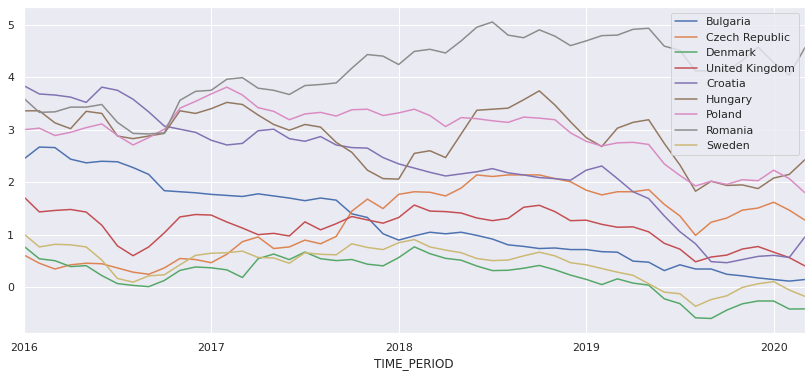

In [21]:
data_labeled.plot()
plt.show()